softmax回归本质上是一个多分类问题
        分类通常多个输出，输出i是预测为第i类的置信度
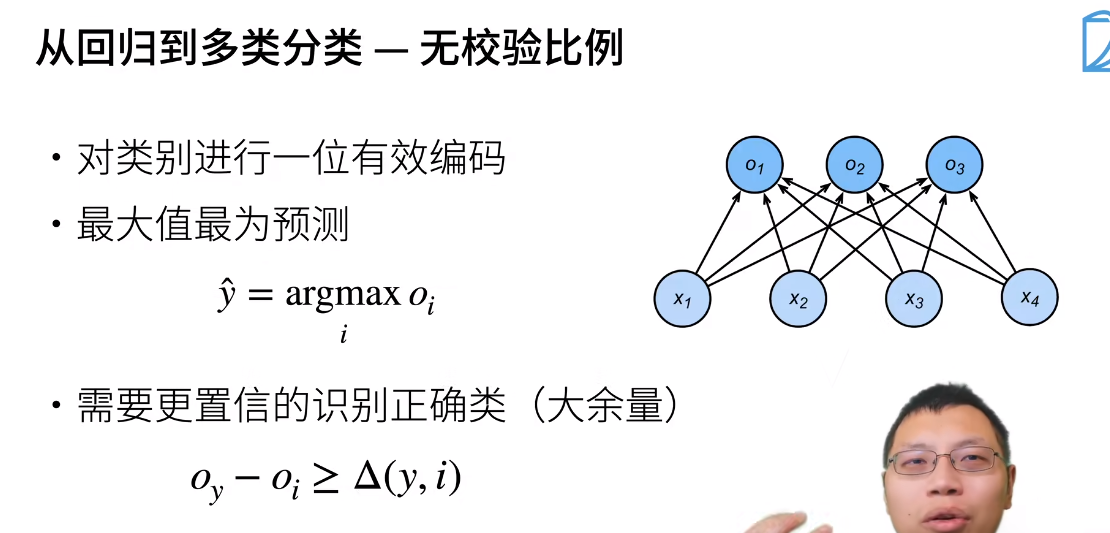
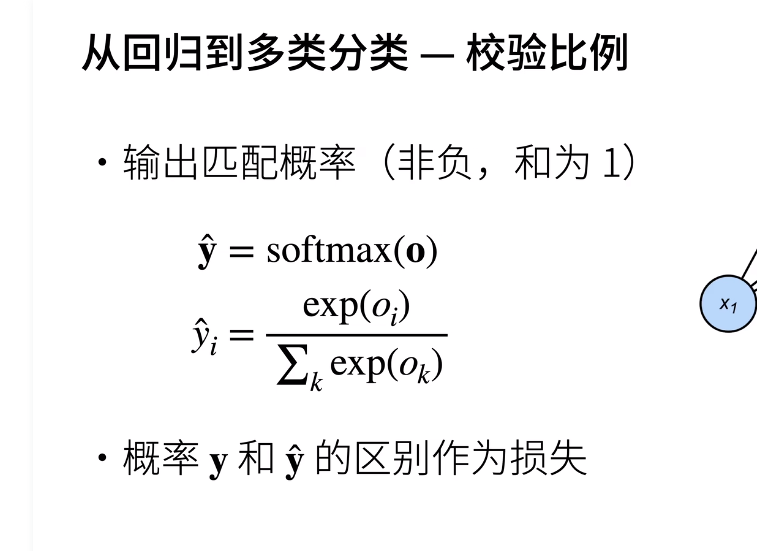
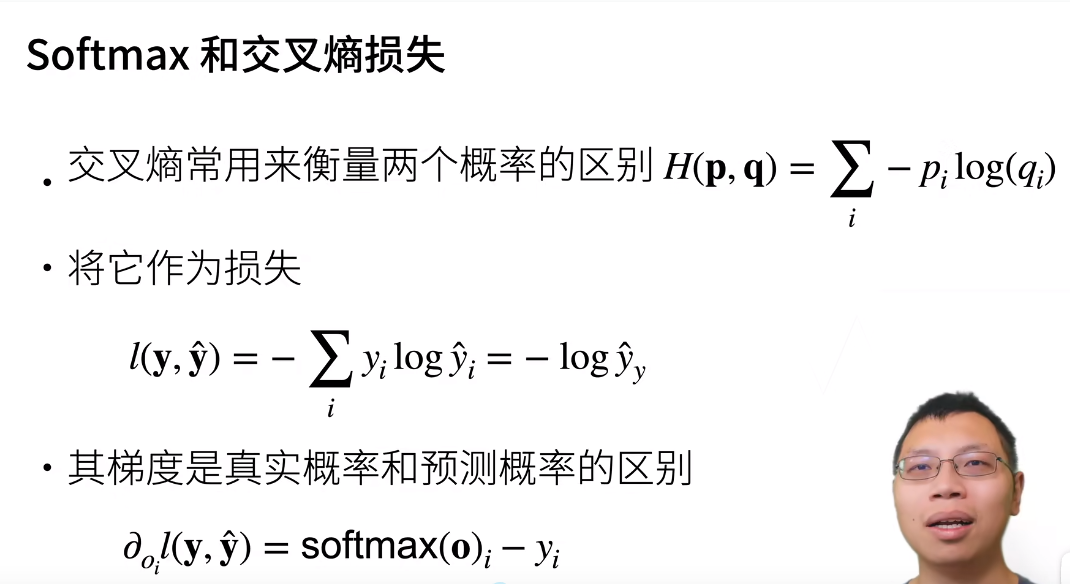
关于softmax梯度推导见：https://blog.csdn.net/weixin_43217928/article/details/104772424
### 注意这里的Oi表示输入softmax的值。
### 我们可以像线性回归那样使用均方损失函数。然而，想要预测分类结果完全正确，我们其实并不需要预测概率完全等于标签概率。只要关心对正确类别的预测概率，只要其值足够大，就可以确保分类结果正确。所以我们使用交叉熵损失函数

# 损失函数
### L2损失函数
  缺点：离原点越远梯度越大
  （蓝色是似然函数，橙色是导数，绿色是损失函数）
  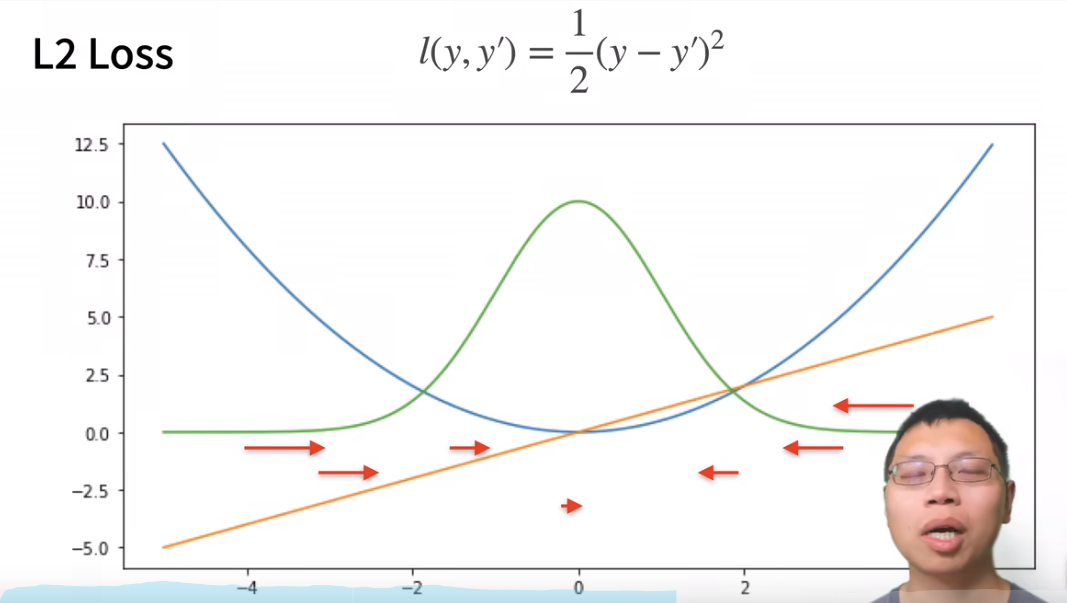
### L1损失函数
  缺点：在原点处不可导，-1到1变化剧烈，不易收敛
  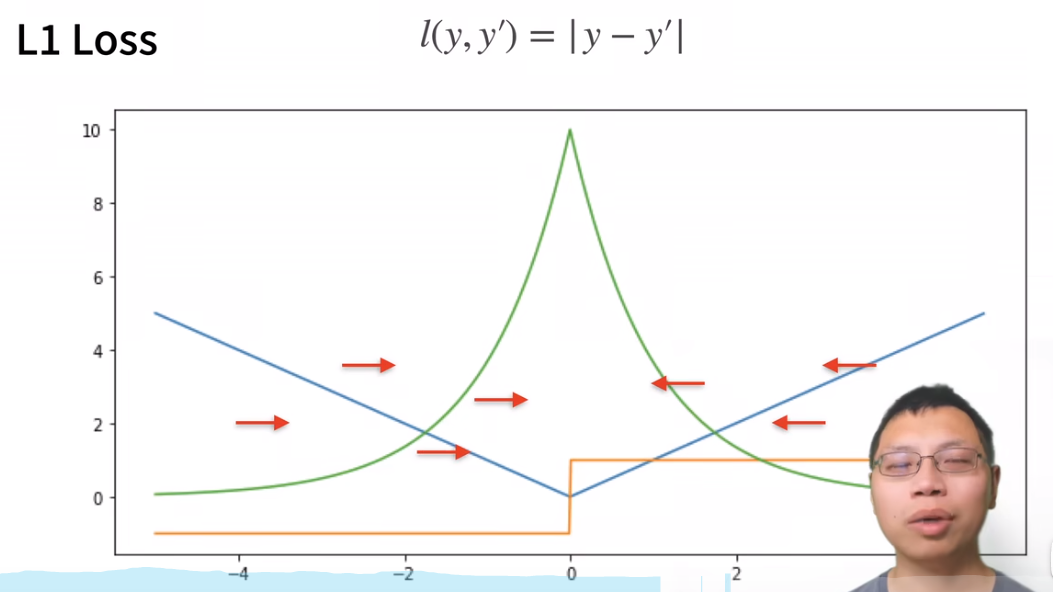
### Hubers's Robust Loss
  结合L1损失和L2损失
  ，解决了-1到1的过度
  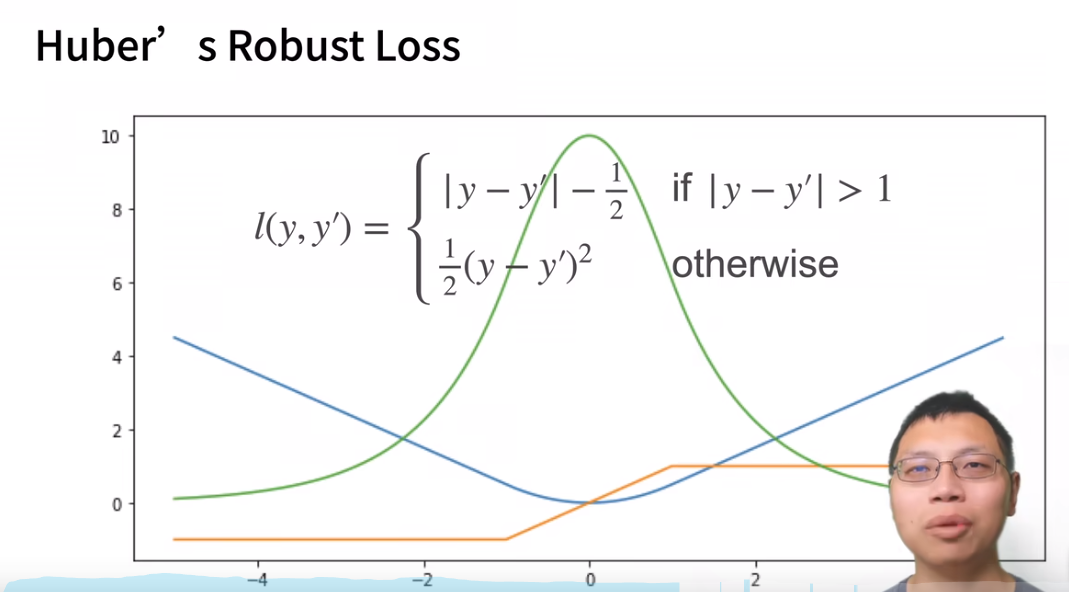

torchvison包是服务于pytorch框架的，主要用来构建计算机视觉模型，主要有以下部分：
1. torchvision.datasets:一些加载数据的函数及常用的数据集接口
2. torchvision.models: 包含常用的模型结构（含预训练模型），例如AlexNet、VGG、ResNet等
3. torchvision.transforms 常用的图片变换，例如裁剪、旋转等
4. torchvision.utils 其他一些有用的方法

In [23]:
import torch
import torchvision
import torch.utils.data as data
from torchvision import transforms

In [24]:
#使用框架中的内置函数将Fashion-MNIST 数据集下载并读取到内存中
#通过ToTensor实例将图像数据从PIL类型转换成32位浮点数格式,时除以255使得所有像素的数值均在0到1之间
#transforms.ToTensor() 将尺⼨为 (H x W x C) 且数据位于[0, 255]的PIL 图⽚或者数据类型为 np.uint8 的 NumPy 数组转换为尺⼨为 (C x H x W) 
#数据类型为torch.float32 且位于[0.0, 1.0]的 Tensor。
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root="../data",train=True,transform=trans,download=True)
mnist_test = torchvision.datasets.FashionMNIST(root="../data",train=False,transform=trans,download=True)
len(mnist_train), len(mnist_test)

(60000, 10000)

In [25]:
mnist_train[0][0].shape #表示第一张图片的向量，因为是黑白图片所以是1，长宽都是28

torch.Size([1, 28, 28])

In [26]:
from IPython import display
def use_svg_display():
    #用矢量图表示,使图像更清晰
    display.set_matplotlib_formats('svg')

In [33]:
#定义一个函数将数值标签转化为文本标签
def get_fashion_mnist_labels(labels): 
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress','coat','sandal', 'shirt', 'sneaker', 'bag', 'ankleboot']
    return [text_labels[int(i)] for i in labels]

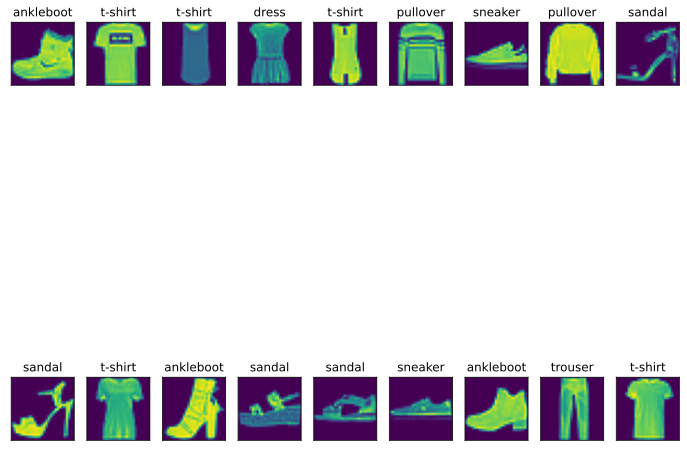

In [45]:
from matplotlib import pyplot as plt
import numpy as np

def show_fashion_mnist(images,labels):
    use_svg_display()
    _,figs=plt.subplots(2,int(len(images)/2),figsize=(12,12))
    figs = figs.flatten() #展平成一个连续范围的维度
    for f,img,label in zip(figs,images,labels):
        f.imshow(img.view(28,28).numpy())#imshow接收的参数必须是M*N,M*N*3,M*N*4
        f.set_title(label)
        f.axes.get_xaxis().set_visible(False) #隐藏x坐标轴
        f.axes.get_yaxis().set_visible(False) #隐藏y坐标轴
    plt.show()
X,y=next(iter(data.DataLoader(mnist_train,batch_size=18)))#next()取出迭代器的一个
show_fashion_mnist(X,get_fashion_mnist_labels(y))

In [74]:
#读取一小批量数据
import time
train_iter = data.DataLoader(mnist_train,batch_size=256,shuffle=True,num_workers=16)
test_iter  = data.DataLoader(mnist_test,batch_size=256)
start=time.time()
for X,y in train_iter:
    continue;
print(f'{time.time()-start} sec')

0.602365255355835 sec


In [75]:
#从0开始实现softmax
import torch
from IPython import display
batch_size = 256

In [76]:
#展平每张图片成为784（28*28）的向量，类别有10类，网络输出维度为10
num_inputs = 784
num_outputs = 10
W = torch.normal(0,0.01,size=(num_inputs,num_outputs),requires_grad=True)
b = torch.zeros(num_outputs,requires_grad=True)
W.shape,b.shape

(torch.Size([784, 10]), torch.Size([10]))

In [77]:
#定义Softmax计算
def softmax(X): #这里X是矩阵
    X_exp = torch.exp(X)
    part = X_exp.sum(1,keepdim=True)
    return X_exp/part #这里利用了广播机制
X = torch.normal(0,1,(2,5))
X_prob = softmax(X)
X_prob,X_prob.sum(1)

(tensor([[0.0286, 0.1726, 0.3036, 0.1828, 0.3124],
         [0.0539, 0.1883, 0.2257, 0.0132, 0.5190]]),
 tensor([1.0000, 1.0000]))

In [145]:
#实现Softmax模型
def net(X):
    return softmax(torch.matmul(X.reshape((-1,W.shape[0])),W)+b)

In [146]:
x = torch.tensor([[0.1,0.3,0.6],[0.3,0.2,0.5]])
y = torch.tensor([0,2])
x[[0,1],y] #相当于取出取出x第一个样本的第0个元素，x第二个样本的第2个元素，即y相当于X每个样本的索引

tensor([0.1000, 0.5000])

In [147]:
#实现交叉熵损失函数
def cross_entropy(y_hat,y):
    return -torch.log(y_hat[list(range(len(y_hat))),y])#相当于把每个样本真实标签的预测值做计算
cross_entropy(x,y) 

tensor([2.3026, 0.6931])

In [148]:
#定义准确率
def accuracy(y_hat,y):
    return ((y_hat.argmax(axis=1)==y).float().mean().item()) #item()将张量变成数值
accuracy(x,y)

0.5

In [149]:
#计算在指定数据集上模型的精度
import torch.nn
def evaluate_accuracy(net,data_iter):
    if isinstance(net,torch.nn.Module): #如果模型是用模块实现的
        net.eval() #将模型设置为评估模型，不计算梯度
    acc, n = 0.0, 0
    for x,y in data_iter:
        acc += accuracy(net(x),y)
        n += 1
    return acc/n

In [168]:
#定义优化函数
def sgd(params,lr,batch_size):#params表示要进行梯度下降优化的参数列表
    with torch.no_grad(): #此时不需要梯度回传
        for param in params:
            param -= lr*param.grad/batch_size
            param.grad.zero_()

In [166]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: plt.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [170]:
#计算损失->梯度清零——>损失梯度回传->梯度优化
def train_ch3(net, train_iter, test_iter, loss, num_epoches, params=None, lr=None,optimizer=None):
#     animator = Animator(xlabel='epoch', xlim=[1, num_epoches], ylim=[0.3, 0.9],
#                         legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epoches):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for x,y in train_iter:
            y_hat = net(x)
            l = loss(y_hat,y).sum()
            if optimizer != None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for para in params:
                    para.grad.data.zero_()
            l.backward()
            if optimizer != None:
                optimizer.step()
            else:
                sgd(params,lr,256)
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(net, test_iter)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'% (epoch + 1, train_l_sum / n, train_acc_sum / n,test_acc))
#         animator.add(epoch+1,[ train_l_sum / n, train_acc_sum / n]+[test_acc])
train_ch3(net,train_iter,test_iter,cross_entropy,num_epoches=10, params=[W,b],lr=0.01)

epoch 1, loss 0.6527, train acc 0.794, test acc 0.785
epoch 2, loss 0.6348, train acc 0.799, test acc 0.789
epoch 3, loss 0.6198, train acc 0.803, test acc 0.795
epoch 4, loss 0.6071, train acc 0.807, test acc 0.797
epoch 5, loss 0.5962, train acc 0.809, test acc 0.800
epoch 6, loss 0.5866, train acc 0.812, test acc 0.804
epoch 7, loss 0.5781, train acc 0.815, test acc 0.805
epoch 8, loss 0.5707, train acc 0.816, test acc 0.806
epoch 9, loss 0.5638, train acc 0.818, test acc 0.809
epoch 10, loss 0.5577, train acc 0.820, test acc 0.810


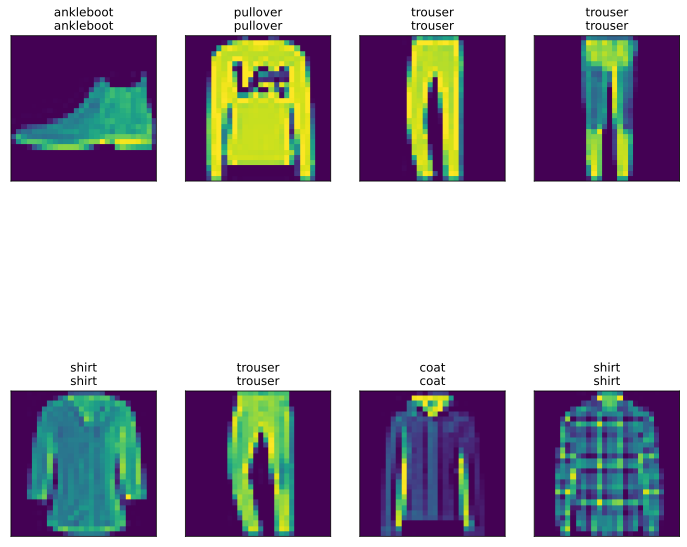

In [173]:
#验证一下
X, y = iter(test_iter).next()
true_labels = get_fashion_mnist_labels(y)
pred_labels =get_fashion_mnist_labels(net(X).argmax(dim=1))
titles = [true + '\n' + pred for true, pred in zip(true_labels,pred_labels)]
show_fashion_mnist(X[0:9], titles[0:9])

In [177]:
from torch import nn

In [178]:
#softmax简介实现
batch_size = 256
net  = nn.Sequential(nn.Flatten(), nn.Linear(784,10))
print(net[1])
net[1].weight.data.normal_(0,0.01)
net[1].bias.data.fill_(0)

Linear(in_features=784, out_features=10, bias=True)


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [179]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(),lr=0.01)

In [185]:
num_epochs = 5
#train_ch3函数和上面一模一样就不写了
train_ch3(net, train_iter, test_iter, loss,100, None, None, optimizer)


epoch 1, loss 0.0054, train acc 0.637, test acc 0.678
epoch 2, loss 0.0036, train acc 0.717, test acc 0.725
epoch 3, loss 0.0031, train acc 0.749, test acc 0.750
epoch 4, loss 0.0029, train acc 0.768, test acc 0.762
epoch 5, loss 0.0028, train acc 0.779, test acc 0.770
epoch 6, loss 0.0026, train acc 0.788, test acc 0.777
epoch 7, loss 0.0026, train acc 0.795, test acc 0.783
epoch 8, loss 0.0025, train acc 0.800, test acc 0.791
epoch 9, loss 0.0024, train acc 0.803, test acc 0.794
epoch 10, loss 0.0024, train acc 0.807, test acc 0.796
epoch 11, loss 0.0023, train acc 0.810, test acc 0.800
epoch 12, loss 0.0023, train acc 0.812, test acc 0.803
epoch 13, loss 0.0023, train acc 0.814, test acc 0.804
epoch 14, loss 0.0022, train acc 0.817, test acc 0.807
epoch 15, loss 0.0022, train acc 0.819, test acc 0.807
epoch 16, loss 0.0022, train acc 0.820, test acc 0.810
epoch 17, loss 0.0022, train acc 0.822, test acc 0.811
epoch 18, loss 0.0021, train acc 0.823, test acc 0.812
epoch 19, loss 0.00